In [3]:
# Core
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = (5, 4)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#load dataset
train_df = pd.read_csv('./titanic-dataset/train.csv')
test_df = pd.read_csv('./titanic-dataset/test.csv')

print("Shape of train dataset: ", train_df.shape)
print("Shape of test dataset: ", test_df.shape)

Shape of train dataset:  (891, 12)
Shape of test dataset:  (418, 11)


In [5]:
#drop PassengerId as we already have pd.DataFrame.index
train_df.drop(['PassengerId'], axis=1, inplace=True)
test_df.drop(['PassengerId'], axis=1, inplace=True)

#drop passenger Name, as it obviously not helping
train_df.drop(['Name'], axis=1, inplace=True)
test_df.drop(['Name'], axis=1, inplace=True)

#change Sex to binary representation female:0 | male:1
train_df.replace({'male':1, 'female':0}, inplace=True)
test_df.replace({'male':1, 'female':0}, inplace=True)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,0,35.0,1,0,113803,53.1000,C123,S
4,0,3,1,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


It looks like, the features have unequal amount of data entries for every column and they have many different types of variables. This can happen for the following reasons...

- We may have missing values in our features.
- We may have categorical features.
- We may have alphanumerical or/and text features.

### 5.a Dealing with missing Values

Let's inspect our dataset for missing values. How many values are missing from each column?

In [8]:
#missing data in train dataset
total = train_df.isnull().sum().sort_values(ascending = False)
percent = total/train_df.shape[0]
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000


In [9]:
#missing data in test dataset
total = test_df.isnull().sum().sort_values(ascending = False)
percent = total/test_df.shape[0]
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000


#### Missing Embarked feature
- train dataset - 2 Nan
- test dataset - 0 Nan

In [10]:
#inspect missing value in train_df's Embarked
train_df[train_df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,0,38.0,0,0,113572,80.0,B28,NaN
829,1,1,0,62.0,0,0,113572,80.0,B28,NaN


Then for a 1st Passenger class with Cabin B: 


C    3
S    2
Name: Embarked, dtype: int64

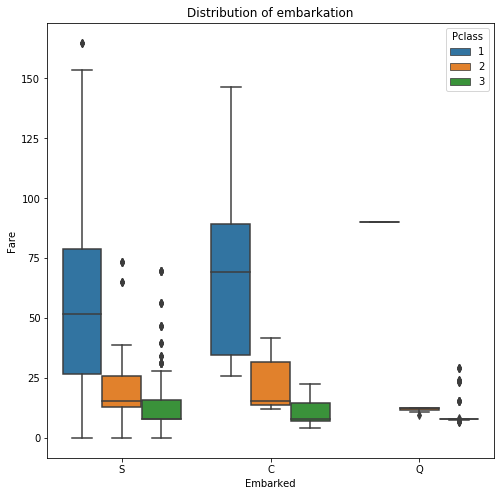

In [11]:
#look at distribution, and see which Embarked group matches the two ladies
feats = ['Pclass', 'Embarked', 'Fare']
dist_df = pd.concat([train_df[feats], test_df[feats]], axis=0) #see dist in both dataset

plt.subplots(figsize=(8,8))
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=dist_df[dist_df.Fare<200]);
plt.title("Distribution of embarkation")

print("Then for a 1st Passenger class with Cabin B: ")
train_df[(train_df.Pclass==1)&(train_df.Cabin.str[0]=='B')&(train_df.Fare>70)&(train_df.Fare<85)].Embarked.value_counts()

In [12]:
#the ladies are more likely to embark from Cheburg (C), hence fillna() with C
train_df.Embarked.fillna('C', inplace=True);
print("Check if fillna works, number of null in train_df's Embarked:", train_df.Embarked.isnull().sum())

Check if fillna works, number of null in train_df's Embarked: 0


#### Missing Cabin feature
 - train dataset - 687
 - test dataset - 327

There is lots of missing data here. You might wonder if the passenger has indeed no luggage/cabin. Or perhaps, the perhaps the Kaggle dataset doesn't record well the passenger Cabin number. 

I would infer it as the passenger not having a Cabin though. Hence, I will rather label those without Cabin as 'N'. In catastrophic cases, bringing luxurious/ valuables might hinder passengers from saving theirself quickly, thinking that they still have enough time to save their valuables before going to the rescue boat. Thus, I'm going to label all Cabin with it's first Alphabet and discard the numeric identifier of that Cabin. The alphabet in the Cabin id might tell the whereabout of the valuables/compartment in the titanic ship.

In [13]:
#labeling missing Cabin as 'N'
train_df.Cabin.fillna('N', inplace=True)
test_df.Cabin.fillna('N', inplace=True)

#label all Cabins with it's initial letter.
train_df.Cabin[train_df.Cabin!='N'] = 'Y'
test_df.Cabin[test_df.Cabin!='N'] = 'Y'

print("Check if fillna works, number of null in train_df's Cabin:", train_df.Cabin.isnull().sum())
display(pd.DataFrame(train_df.Cabin.value_counts()))

Check if fillna works, number of null in train_df's Cabin: 0


,Cabin
N,687
Y,204


#### Missing Fare feature
- train dataset - 0
- test dataset - 1

Here, We can take the average of the Fare column with all the values to fill in for Nan Fare value. However, that might not be the best way to fill in this value. We can be a little more specific and take the average of the values wherePclass is 3, Sex is male and Embarked is S

In [14]:
#inspect mising value in test dataset's Fare
test_df[test_df.Fare.isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,1,60.5,0,0,3701,NaN,N,S


In [15]:
#looking at the above boxplot distribution, the sir is morelikely to pay:
mean = train_df[(train_df.Embarked=='S')&(train_df.Pclass==3)].Fare.mean()
print("Mean Fare for 3rd SocioClass coming from SouthHampton: USD", mean)

#fillna
test_df.Fare.fillna(mean, inplace=True)
print("Check if fillna works, number of null in Fare:", test_df.Fare.isnull().sum())

Mean Fare for 3rd SocioClass coming from SouthHampton: USD 14.644083002832863
Check if fillna works, number of null in Fare: 0


#### Age Feature
- train dataset - 177
- test dataset - 86

Some simple way to deal with missing values is, well... just give the average or median age of all passenger. Simple enough, but is it good enough? Age feature is an important feature in our classification task as we will see later using **Hypothesis testing** (yes! finally a Cambridge Math A level in action huh?). Getting the NaN value right is pretty crucial then. 

So how are we going to deal with these NaN? One way is being more thorough as we have done to missing Fare with that one free loader guy! A more robust an elegant way is to use a **regresssion model**. And since we have handle all missing values other than Age hence, we are good to go for **regression method** to fill NaN value.

Too soon? Nope! Once more unto the bridge!

In [16]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,A/5 21171,7.2500,N,S
1,1,1,0,38.0,1,0,PC 17599,71.2833,Y,C
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,1,1,0,35.0,1,0,113803,53.1000,Y,S
4,0,3,1,35.0,0,0,373450,8.0500,N,S


In [17]:
from sklearn.ensemble import RandomForestRegressor
#define a function to complete the missing age
def rforest_completing_age(df, trainable, feats):
    #target --> df with Nan age value
    target = df[df.Age.isnull()]
    y_train = trainable.Age.values
    X_train, X_test = trainable[feats], target[feats]
    #train fit model: random forest regressor
    r_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=6)
    r_forest.fit(X_train, y_train)
    #output prediction to NaN age
    y_pred = r_forest.predict(X_test)
    
    return y_pred

Well we take the dataset in train_df that has valid Age value (not null) to predict and complete other missing value. We call this dataset the trainable just for the scope of this fillna-regression method. Before that, let's really check the trainable dataset if there is any null. If all is good, we are ready to go.

In [18]:
#dataset to predict missing age value is those in train_df with valid Age value
trainable = train_df[train_df.Age.notnull()] 
trainable.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [19]:
#fill missing Age in train dataset
feats = ['Survived', 'Sex', 'SibSp', 'Parch', 'Fare']
train_df.loc[train_df.Age.isnull(), 'Age'] = rforest_completing_age(train_df, trainable, feats)

#check if all NaN age has finally filled
train_df.Age.isnull().sum()

0

In [20]:
#fill missing Age in test dataset
feats = ['Sex', 'SibSp', 'Parch', 'Fare']
test_df.loc[test_df.Age.isnull(), 'Age'] = rforest_completing_age(test_df,  #use pd.DataFame.loc[:,:] method for assignment
                                                                  trainable, 
                                                                  feats) 
#check if all Nan ge has finally filled
test_df.Age.isnull().sum()

0

Last check thoo, let's take a look at Age distribution across train and test dataset

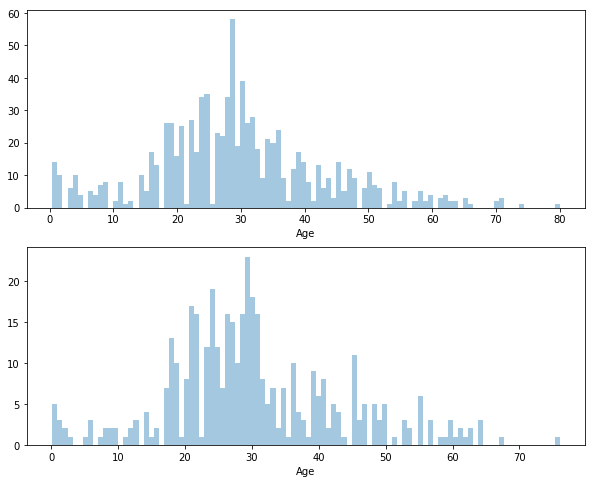

In [21]:
#peeping
_, axes = plt.subplots(2, 1, figsize=(10,8))

sns.distplot(train_df.Age, bins=100, kde=False, rug=False, norm_hist=False, ax=axes[0])
sns.distplot(test_df.Age, bins=100, kde=False, rug=False, norm_hist=False, ax=axes[1])

### 5.b Feature Engineering

#### Cabin - Binary representation

In [22]:
# #should have been straight forward, replace Cabin with binary rep
train_df.Cabin.replace({'N':0, 'Y':1}, inplace=True)
test_df.Cabin.replace({'N':0, 'Y':1}, inplace=True);

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,A/5 21171,7.2500,0,S
1,1,1,0,38.0,1,0,PC 17599,71.2833,1,C
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,1,1,0,35.0,1,0,113803,53.1000,1,S
4,0,3,1,35.0,0,0,373450,8.0500,0,S


#### Age binning/grouping - Ordinal

In [23]:
#group Age values into bins
bins = [0,1,4,13,18,35,45,55,65,120]
labels = [1,2,3,4,5,6,7,8,9]

#using pd.cut
train_df['binage'] = pd.cut(train_df.Age, bins=bins, labels=labels)
train_df['binage'] = train_df['binage'].astype('int')

test_df['binage'] = pd.cut(test_df.Age, bins=bins, labels=labels)
test_df['binage'] = test_df['binage'].astype('int')

test_df.tail()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binage
413,3,1,28.495945,0,0,A.5. 3236,8.0500,0,S,5
414,1,0,39.000000,0,0,PC 17758,108.9000,1,C,6
415,3,1,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,0,S,6
416,3,1,28.495945,0,0,359309,8.0500,0,S,5
417,3,1,18.880692,1,1,2668,22.3583,0,C,5


#### Family Size feature - Numerical
Having to know the family size might be a good feature for our model. In dire situation, passenger might be concerned about family member as a whole (siblings, spouse, children, and parents) and this might affect their survival rate. 

In [24]:
#Siblings, Spouse, Parents, and Children = 1 family 
train_df['famsize'] = train_df.SibSp + train_df.Parch + 1
test_df['famsize'] = test_df.SibSp + test_df.Parch + 1

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binage,famsize
0,0,3,1,22.0,1,0,A/5 21171,7.2500,0,S,5,2
1,1,1,0,38.0,1,0,PC 17599,71.2833,1,C,6,2
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,5,1
3,1,1,0,35.0,1,0,113803,53.1000,1,S,5,2
4,0,3,1,35.0,0,0,373450,8.0500,0,S,5,1


#### Is Alone feature - Boolean
This might be a good feature. We will see if Boolean (traveling with family or not) feature is enough and better than giving information about the family size who were travel with passengers.

In [25]:
#is alone?
train_df['isalone'] = (train_df.famsize<=1).astype('int')
test_df['isalone'] = (train_df.famsize<=1).astype('int')

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binage,famsize,isalone
0,0,3,1,22.0,1,0,A/5 21171,7.2500,0,S,5,2,0
1,1,1,0,38.0,1,0,PC 17599,71.2833,1,C,6,2,0
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,5,1,1
3,1,1,0,35.0,1,0,113803,53.1000,1,S,5,2,0
4,0,3,1,35.0,0,0,373450,8.0500,0,S,5,1,1


#### Fare binning/grouping - Ordinal

In [26]:
#fare grouping
bins = [0, 10, 25, 50, 150, 600]
labels = ['verycheap', 'low', 'middle', 'upper', 'elite']

train_df['fare_group'] = pd.cut(train_df.Fare, bins=bins, labels=labels)
test_df['fare_group'] = pd.cut(test_df.Fare, bins=bins, labels=labels)

test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binage,famsize,isalone,fare_group
0,3,1,34.5,0,0,330911,7.8292,0,Q,5,1,0,verycheap
1,3,0,47.0,1,0,363272,7.0000,0,S,7,2,0,verycheap
2,2,1,62.0,0,0,240276,9.6875,0,Q,8,1,1,verycheap
3,3,1,27.0,0,0,315154,8.6625,0,S,5,1,0,verycheap
4,3,0,22.0,1,1,3101298,12.2875,0,S,5,3,1,low


### One-hot A.K.A Dummy Variable
- Embarked - Categorical
- Pclass - Ordinal/Categorical
- fare_group - Categorical

In [27]:
#first, change the Pclass value to some string
train_df.Pclass.replace({1:'upper', 2: 'middle', 3: 'lower'}, inplace=True)
test_df.Pclass.replace({1:'upper', 2: 'middle', 3: 'lower'}, inplace=True);

In [28]:
feats = ['Embarked', 'fare_group', 'Pclass']
#train_df
one_hot = pd.get_dummies(train_df[feats], drop_first=True)
train_df = train_df.join(one_hot)
#test_df
one_hot = pd.get_dummies(test_df[feats], drop_first=True)
test_df = test_df.join(one_hot)

test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binage,...,isalone,fare_group,Embarked_Q,Embarked_S,fare_group_low,fare_group_middle,fare_group_upper,fare_group_elite,Pclass_middle,Pclass_upper
0,lower,1,34.5,0,0,330911,7.8292,0,Q,5,...,0,verycheap,1,0,0,0,0,0,0,0
1,lower,0,47.0,1,0,363272,7.0000,0,S,7,...,0,verycheap,0,1,0,0,0,0,0,0
2,middle,1,62.0,0,0,240276,9.6875,0,Q,8,...,1,verycheap,1,0,0,0,0,0,1,0
3,lower,1,27.0,0,0,315154,8.6625,0,S,5,...,0,verycheap,0,1,0,0,0,0,0,0
4,lower,0,22.0,1,1,3101298,12.2875,0,S,5,...,1,low,0,1,1,0,0,0,0,0


#### Dropping weak/ useless features
- Ticket: ticket number is not a lucky number. Is completely uncorrelated and unrelated to survival rate
- Pclass: we replace this feature with one-hot encoding using of fare_group, as passenger fare 

In [29]:
# drop unwanted features
dropfeats = ['Ticket', 'fare_group', 'Pclass', 'SibSp', 'Embarked']
#dropping
train_df_prep = train_df.drop(dropfeats, axis=1)
test_df_prep = test_df.drop(dropfeats, axis=1)

display(train_df_prep.head(), test_df_prep.head())

,Survived,Sex,Age,Parch,Fare,Cabin,binage,famsize,isalone,Embarked_Q,Embarked_S,fare_group_low,fare_group_middle,fare_group_upper,fare_group_elite,Pclass_middle,Pclass_upper
0,0,1,22.0,0,7.2500,0,5,2,0,0,1,0,0,0,0,0,0
1,1,0,38.0,0,71.2833,1,6,2,0,0,0,0,0,1,0,0,1
2,1,0,26.0,0,7.9250,0,5,1,1,0,1,0,0,0,0,0,0
3,1,0,35.0,0,53.1000,1,5,2,0,0,1,0,0,1,0,0,1
4,0,1,35.0,0,8.0500,0,5,1,1,0,1,0,0,0,0,0,0


,Sex,Age,Parch,Fare,Cabin,binage,famsize,isalone,Embarked_Q,Embarked_S,fare_group_low,fare_group_middle,fare_group_upper,fare_group_elite,Pclass_middle,Pclass_upper
0,1,34.5,0,7.8292,0,5,1,0,1,0,0,0,0,0,0,0
1,0,47.0,0,7.0000,0,7,2,0,0,1,0,0,0,0,0,0
2,1,62.0,0,9.6875,0,8,1,1,1,0,0,0,0,0,1,0
3,1,27.0,0,8.6625,0,5,1,0,0,1,0,0,0,0,0,0
4,0,22.0,1,12.2875,0,5,3,1,0,1,1,0,0,0,0,0


In [30]:
#train dataset data type
train_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
Survived             891 non-null int64
Sex                  891 non-null int64
Age                  891 non-null float64
Parch                891 non-null int64
Fare                 891 non-null float64
Cabin                891 non-null int64
binage               891 non-null int64
famsize              891 non-null int64
isalone              891 non-null int64
Embarked_Q           891 non-null uint8
Embarked_S           891 non-null uint8
fare_group_low       891 non-null uint8
fare_group_middle    891 non-null uint8
fare_group_upper     891 non-null uint8
fare_group_elite     891 non-null uint8
Pclass_middle        891 non-null uint8
Pclass_upper         891 non-null uint8
dtypes: float64(2), int64(7), uint8(8)
memory usage: 69.7 KB


In [31]:
#test dataset data type
test_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
Sex                  418 non-null int64
Age                  418 non-null float64
Parch                418 non-null int64
Fare                 418 non-null float64
Cabin                418 non-null int64
binage               418 non-null int64
famsize              418 non-null int64
isalone              418 non-null int64
Embarked_Q           418 non-null uint8
Embarked_S           418 non-null uint8
fare_group_low       418 non-null uint8
fare_group_middle    418 non-null uint8
fare_group_upper     418 non-null uint8
fare_group_elite     418 non-null uint8
Pclass_middle        418 non-null uint8
Pclass_upper         418 non-null uint8
dtypes: float64(2), int64(6), uint8(8)
memory usage: 29.5 KB


## 6. Logistic Regression - Intro to Modelling
Here comes the exciting part...

### 6.a Basics of Modelling
Machine learning is about data preprocessing, apply machine learning models, rinse and repeat.
The most simple modelling procedure is basically splitting data into train and validation (often called test), then training models and finally, model evaluation.

In [32]:
#Split target variable (Survived) from the training dataset
y = train_df_prep['Survived'] #.Survived
X = train_df_prep.drop(['Survived'], axis=1)

Splitting training dataset

In [33]:
#Split training dataset into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of Training dataset and label:", X_train.shape, y_train.shape)
print("Shape of Validation dataset and label:", X_test.shape, y_test.shape)

Shape of Training dataset and label: (623, 16) (623,)
Shape of Validation dataset and label: (268, 16) (268,)


In [34]:
X_train.head()

,Sex,Age,Parch,Fare,Cabin,binage,famsize,isalone,Embarked_Q,Embarked_S,fare_group_low,fare_group_middle,fare_group_upper,fare_group_elite,Pclass_middle,Pclass_upper
445,1,4.000000,2,81.8583,1,2,3,0,0,1,0,0,1,0,0,1
650,1,28.635154,0,7.8958,0,5,1,1,0,1,0,0,0,0,0,0
172,0,1.000000,1,11.1333,0,1,3,0,0,1,1,0,0,0,0,0
450,1,36.000000,2,27.7500,0,6,4,0,0,1,0,1,0,0,1,0
314,1,43.000000,1,26.2500,0,6,3,0,0,1,0,1,0,0,1,0


Feature Scalling/ Input Norm

In [35]:
#numerical/floating features
float_feats = ['Age', 'Fare']

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train[float_feats] = std_scaler.fit_transform(X_train[float_feats])
X_test[float_feats] = std_scaler.transform(X_test[float_feats])

X_train.head()

,Sex,Age,Parch,Fare,Cabin,binage,famsize,isalone,Embarked_Q,Embarked_S,fare_group_low,fare_group_middle,fare_group_upper,fare_group_elite,Pclass_middle,Pclass_upper
445,1,-1.882223,2,0.980998,1,2,3,0,0,1,0,0,1,0,0,1
650,1,-0.047747,0,-0.469634,0,5,1,1,0,1,0,0,0,0,0,0
172,0,-2.105620,1,-0.406136,0,1,3,0,0,1,1,0,0,0,0,0
450,1,0.500682,2,-0.080232,0,6,4,0,0,1,0,1,0,0,1,0
314,1,1.021943,1,-0.109651,0,6,3,0,0,1,0,1,0,0,1,0


### 6.b Basics Training and Evaluation

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_pred, y_test))

Accuracy Score:  0.8171641791044776


### 6.c K-Fold Cross Validation
Integrity of model evaluation in Data Splitting. Now we have our score from logistic regression model. Satisfied? Maybe... But before we search for improvements, ask yourself: how do you make sure that our model perform well, not underfit or overfit? 

[some picts about overfit vs underfit]

You can compare the train and test accuracy score to see if the model is overfit. To make your procedure more robust, try **K-Fold cross validation** intead of **Train-Test-Split** method. K Fold CV is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.The goal of cross-validation is to test the model’s ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

In [42]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

scores = []
model = log_reg
for train_idx, test_idx in kf.split(X):
    #training
    model.fit(X.loc[train_idx], y.loc[train_idx])
    y_pred = model.predict(X.loc[test_idx])
    scores.append(accuracy_score(y.loc[test_idx], y_pred))

In [44]:
np.array(scores).mean()

0.8002122347066167

In [45]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator=log_reg, X=X_train, y=y_train, cv=10, n_jobs=-1)
acc_mean = accuracies.mean()

print("Mean of Training Accuracy:", acc_mean)

Mean of Training Accuracy: 0.8042394713261649


Besides K-Fold there are many more ways to split our dataset for training-validation purposes:
- ShuffleSplit
- StratifiedShuffleSplit
- StratifiedKFold
- Group KFold

### 6.d GridSearch on Logistic Regression
If you look at the documentation of Logistic Regression classifier, you will find many hyperparameters which we didn't even specify one before. We just used all default values on our classifier. Hyperparameters choices will affect the performance of our data. One hyperparameters settings might suits better to one distributions. 

In order select the most optimum settings, should hardcode all possible hyperparameters? Well, actually yes and no. Yes you have to but GridSearch method will do it for you so you don't have to make forloops or even worst, write codes over and over again.

Logistic Regression hyperparameters:
- C: inverse of regularization strength
- penalty: specify norm used for penalization
- fit_intercept: specify if a constant should be added to function 

In [187]:
from sklearn.model_selection import GridSearchCV

#lists all possibilities
C = [0.099,0.1,0.2,0.5,2]
penalties = ['l1', 'l2']

hyperparams = {
    'C':C,
    'penalty': penalties,
    'fit_intercept': [True, False]
}

#initialize grid search
grid_search = GridSearchCV(estimator=log_reg, 
                           param_grid = hyperparams,
                           scoring = 'accuracy', 
                           cv = 10)


In [192]:
#grid searching
grid_search = grid_search.fit(X_train, y_train)

print("Best hypermeters tuning:", grid_search.best_params_)
print("Best hypermeters tuning:", grid_search.best_score_)

Best hypermeters tuning: {'C': 0.2, 'fit_intercept': True, 'penalty': 'l2'}
Best hypermeters tuning: 0.8202247191011236


In [236]:
#evaluate grid search hyperparams
log_reg_grid = grid_search.best_estimator_
y_pred = log_reg_grid.predict(X_test)
print("Accuracy Score: ", log_reg_grid.score(X_test, y_test)) 

Accuracy Score:  0.8171641791044776


Ask yourself, why the so called best tuning is not better than default at all?

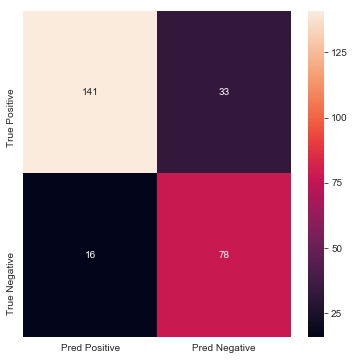

In [237]:
from sklearn.metrics import classification_report, confusion_matrix

#calculate
clf_report = classification_report(y_test, y_pred, labels=log_reg_grid.classes_)
cm = confusion_matrix(y_pred, y_test)
#visualize
plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=['Pred Positive', 'Pred Negative'],
            yticklabels=['True Positive', 'True Negative'])

In [238]:
#report
print(clf_report)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       157
           1       0.83      0.70      0.76       111

   micro avg       0.82      0.82      0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268



0.8758248694554427


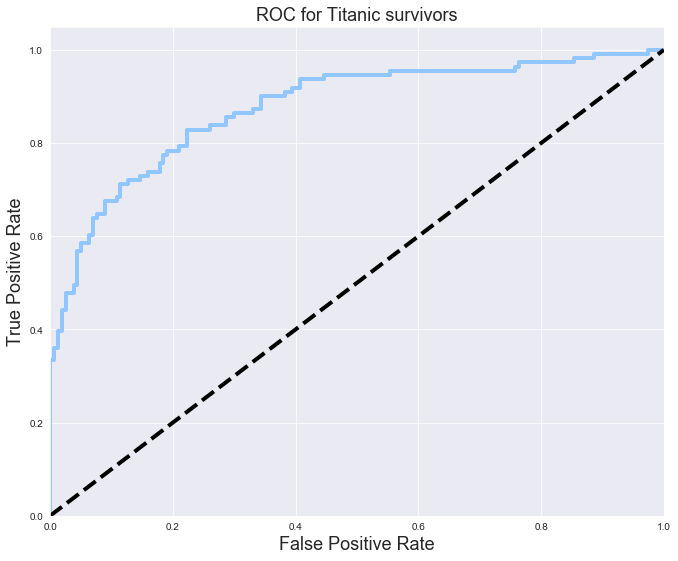

In [215]:
from sklearn.metrics import roc_curve, auc
sns.set_style("darkgrid")
plt.style.use('seaborn-pastel')

y_score = log_reg_grid.decision_function(X_test)

FPR, TPR, thresh = roc_curve(y_test, y_score)
ROC_AUC = auc(FPR,TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Titanic survivors', fontsize= 18)
plt.show()

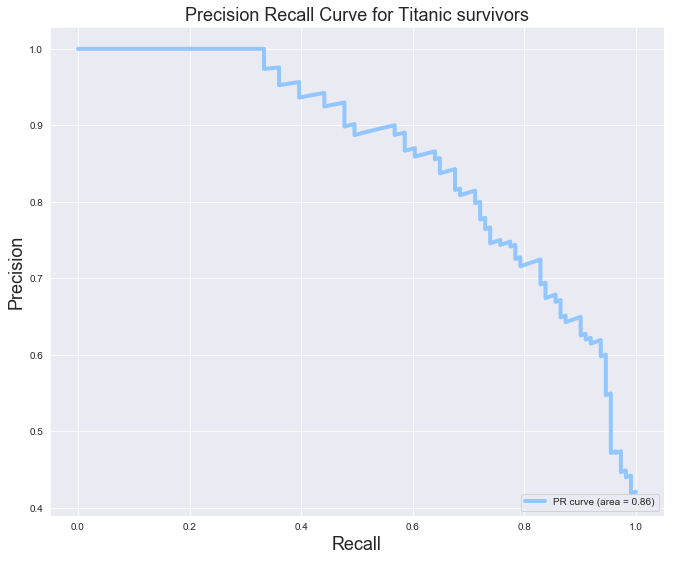

In [217]:
from sklearn.metrics import precision_recall_curve

plt.style.use('seaborn-pastel')

y_score = log_reg_grid.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_score)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Titanic survivors', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## 7. Random Forest Classifier

In [221]:
from sklearn.ensemble import RandomForestClassifier

rforest_clf = RandomForestClassifier(n_estimators=150, max_depth=6, n_jobs=-1, random_state=42, oob_score = True)
rforest_clf.fit(X_train, y_train)

print("Out-of-Bag score on train dataset:", rforest_clf.oob_score_ )
print("Accuracy score for Validation:", rforest_clf.score(X_test, y_test))

Out-of-Bag score on train dataset: 0.8298555377207063
Accuracy score for Validation: 0.8134328358208955


### Grid search on Random Forest Classifier

In [233]:
from sklearn.model_selection import GridSearchCV

n_ests = [150, 200, 350]
criterion = ['gini', 'entropy']
max_depth = [5, 6, 8]


hyperparams = {
    'n_estimators':n_ests,
    'criterion': criterion,
    'max_depth': max_depth,
    
}
grid_search = GridSearchCV(estimator=rforest_clf,
                          param_grid=hyperparams,
                          scoring='accuracy',
                          cv=7)

In [234]:
#grid searching
#Warning: Before you re-run this cell, the execution time will take very long...
grid_search = grid_search.fit(X_train, y_train)
rforest_grid = grid_search.best_estimator_
y_pred = rforest_grid.predict(X_test)

print("Best hypermeters tuning:", grid_search.best_params_)
print("Best hypermeters tuning:", grid_search.best_score_)
print("Grid Search accuracy score:", rforest_grid.score(X_test, y_test))

Best hypermeters tuning: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 350}
Best hypermeters tuning: 0.8330658105939005
Grid Search accuracy score: 0.8171641791044776


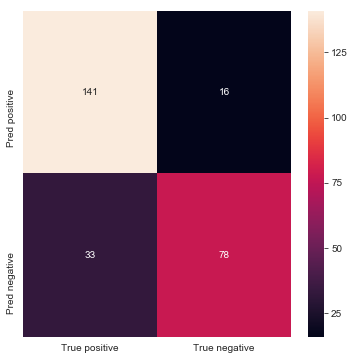

In [241]:
#evaluation
y_pred = rforest_grid.predict(X_test)
clf_report = classification_report(y_test, y_pred, rforest_grid.classes_)
cm = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=["True positive", "True negative"],
           yticklabels=["Pred positive", "Pred negative"])

In [242]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       157
           1       0.83      0.70      0.76       111

   micro avg       0.82      0.82      0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268



In [253]:
#ROC AUC metrics 
y_score = rforest_grid.predict_proba(X_test)
y_score = y_score[:,1]
FPR, TPR, _ = roc_curve(y_test, y_score)
ROC_AUC = auc(FPR, TPR)
print(ROC_AUC)

0.8892810007459689


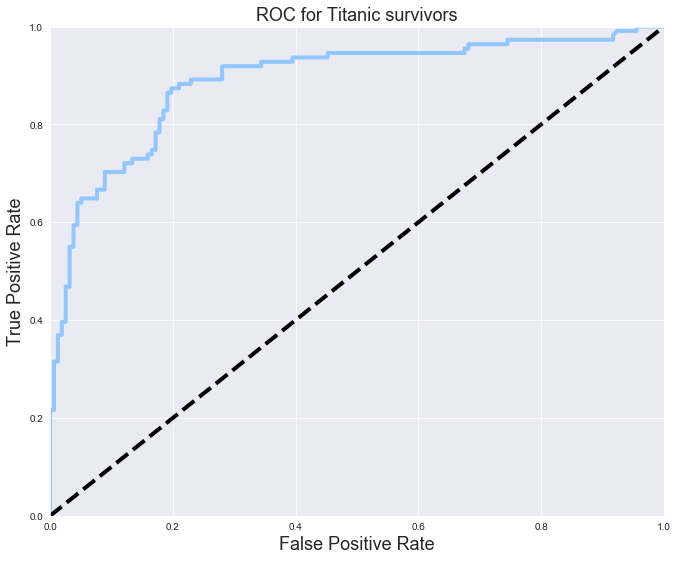

In [256]:
#plotting
plt.figure(figsize=(11,9))
plt.plot(FPR, TPR, label="ROC curve (area%0.2f)"%ROC_AUC, linewidth=4)
plt.plot([0,1], [0,1], 'k--', linewidth=4)
plt.xlim((0.0, 1.0))
plt.ylim((0.0,1.0))
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Titanic survivors', fontsize= 18)
plt.show()